In [3]:
from pyspark.sql import SparkSession
import os
    
# get ip address of master node (current machine)
ip = os.popen('hostname -i').read().strip('\n')
spark = SparkSession.builder \
    .master('local[28]') \
    .appName('wiki') \
    .config("spark.driver.maxResultSize", "3g")\
    .getOrCreate()
print 'Spark Session web UI: http://{}:4040'.format(ip)


Spark Session web UI: http://10.50.221.73:4040


# PMI embedding

### (a) calculate PMI of (wi, wj)

In [12]:
from pyspark import SparkContext
sc = spark.sparkContext
wiki_file = open('/project/cmsc25025/wikipedia/wiki-text.txt','r').readlines()[0]
num_chunks = 4 * 28 #make it multiple of number of your cores
chunks, chunk_size = len(wiki_file), len(wiki_file)/num_chunks
wiki_chunks = [wiki_file[i:i+chunk_size] for i in range(0, chunks, chunk_size)]
wiki_data = sc.parallelize(wiki_chunks,4*28)

In [13]:
# Get the raw vocabulary 
raw_voc = wiki_data.flatMap(lambda doc: doc.split()).map(lambda word: (word,1)).reduceByKey(lambda a, b: a+b).collect()


In [14]:
# load stopwords
import nltk
from nltk.corpus import stopwords
stops = set(stopwords.words('english'))

In [15]:
# Build vocabulary based on the raw vocabulary for word not in stops and occurance larger than 500
voc = {}
min_word_freq = 500
for key, val in raw_voc:
    if val > min_word_freq and key not in stops:
        voc[key] = val
voc_size = len(voc)
print 'The vocabulary size is %d.' % voc_size

The vocabulary size is 13221.


In [18]:
def iter_pair(x):
    #Count pairs
    x = x.split()
    words = [word for word in x if word in voc]
    text_size = len(words)
    pairs = []
    win = 5
    for i in range(win, text_size - win):
        for j in range(i - win, i + win + 1):
            pairs.append((tuple([words[i],words[j]]), 1))
    return pairs 
PMI = wiki_data.flatMap(iter_pair).reduceByKey(lambda a, b: a+b).collect()

In [74]:
print PMI[0]

(('privatization', 'responded'), 2)


In [16]:
index = {}
ivoc = []
for i, key in enumerate(voc):
    index[key] = i
    ivoc.append(key)

### (b) Compute matrix M

In [75]:
import numpy as np

M = np.zeros((voc_size, voc_size))
for key, val in PMI:
    i = index[key[0]]
    j = index[key[1]]
    M[i][j] = val 
D = np.sum(M > 0)


In [76]:
import math
M2 = np.zeros((voc_size, voc_size))
for i in range(voc_size):
    for j in range(i, voc_size):
        M2[i][j] = math.log((M[i][j] + 1) / voc[ivoc[i]] / voc[ivoc[j]] * D)
        M2[j][i] = M2[i][j]

In [64]:
from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix
U, s, V = svds(scipy.sparse.csr_matrix(M2), k = 50)


### (c) Get learned PMI word embeddings

In [65]:
s_sq = np.sqrt(s)
W = np.zeros(U.shape)
for col in range(50):
    W[:,col] = U[:,col] * s_sq[col]


In [66]:
print W.shape
print W[:, 0]

(13221, 50)
[-0.01684306 -0.25730956  0.39965732 ...,  0.12920123  0.03052353
  0.09896645]


Serialize embeddings using Pickle

In [17]:
try:
    import cPickle as pickle
except:
    import pickle
word_emb = open('words_embedding', 'wb')
skip_voc = open('voc', 'wb')
pickle.dump(W, word_emb)
pickle.dump(voc, skip_voc)
word_emb.close()
skip_voc.close()

In [2]:
try:
    import cPickle as pickle
except:
    import pickle
word_emb = open('words_embedding', 'rb')
W = pickle.load(word_emb)
skip_voc = open('voc', 'rb')
voc = pickle.load(skip_voc)
word_emb.close()
skip_voc.close()

In [9]:
index = {}
ivoc = []
for i, key in enumerate(voc):
    index[key] = i
    ivoc.append(key)

# Glove

In [4]:
vocab_file = 'GloVe/wiki-vocab.txt'
vectors_file = 'GloVe/wiki-vectors.txt'
with open(vocab_file, 'r') as f:
    words = [x.rstrip().split(' ')[0] for x in f.readlines()]
with open(vectors_file, 'r') as f:
    vectors = {}
    for line in f:
        vals = line.rstrip().split(' ')
        vectors[vals[0]] = [float(x) for x in vals[1:]]
vocab = {w: idx for idx, w in enumerate(words)}
ivocab = {idx: w for idx, w in enumerate(words)}

# Pretrained word vectors

In [6]:
giwa_vector_file = 'glove6B/glove.6B.50d.txt'
with open(giwa_vector_file, 'r') as f:
    giwa_vectors = {}
    for line in f:
        vals = line.rstrip().split(' ')
        giwa_vectors[vals[0]] = [float(x) for x in vals[1:]]
giwa_vocab = {}
giwa_ivocab = {}
for idx, w in enumerate(giwa_vectors):
    giwa_vocab[w] = idx
    giwa_ivocab[idx] = w
    


# Experiments

## (a)

In [7]:
#from pyspark import SparkContext
#sc = spark.sparkContext
checklist = ['physics', 'republican', 'einstein', 'algebra', 'fish']
W_rdd = sc.parallelize(enumerate(W), 4 * 28)
glove = sc.parallelize(vectors, 4 * 28)
giwa = sc.parallelize(giwa_vectors, 4 * 28)
print 'Size of vocabulary with three sets of embeddings:'
print 'Skip-gram:\t%d' % W_rdd.count() 
print 'GloVe:\t\t%d' % glove.count() 
print 'Gigaword:\t%d' % giwa.count() 

Size of vocabulary with three sets of embeddings:
Skip-gram:	13221
GloVe:		56467
Gigaword:	400000


## (b)

In [37]:
for w in checklist:
    print w
    print '-----------------------------'
    skip_vec = W[index[w],:]
    skip_w = W_rdd.map(lambda x: (ivoc[x[0]], np.linalg.norm(x[1] - skip_vec))).takeOrdered(6, key=lambda x: x[1])
    print 'Skip-gram:'
    print [w for w, prod in skip_w[1:]]
    glove_vec = np.array(vectors[w])
    glove_w = glove.map(lambda x: (x, np.linalg.norm(np.array(vectors[x]) - glove_vec))).takeOrdered(6, key=lambda x: x[1])
    print 'GloVe:'
    print [w for w, prod in glove_w[1:]]
    giwa_vec = np.array(giwa_vectors[w])
    giwa_w = giwa.map(lambda x: (x, np.linalg.norm(np.array(giwa_vectors[x]) - giwa_vec))).takeOrdered(6, key=lambda x: x[1])  
    print 'Gigaword:'
    print [w for w, prod in giwa_w[1:]]
    print '\n\n'

physics
-----------------------------
Skip-gram:
['mechanics', 'quantum', 'theoretical', 'chemistry', 'mathematics']
GloVe:
['mathematical', 'physics', 'calculus', 'theoretical', 'studying']
Gigaword:
['studied', 'studies', 'study', 'taught', 'teaching']



republican
-----------------------------
Skip-gram:
['senator', 'democrat', 'democrats', 'republicans', 'presidential']
GloVe:
['candidates', 'presidency', 'senate', 'election', 'elections']
Gigaword:
['election', 'parliamentary', 'vote', 'polls', 'electoral']



einstein
-----------------------------
Skip-gram:
['relativity', 'physicists', 'planck', 'paradox', 'leibniz']
GloVe:
['gottfried', 'nietzsche', 'relates', 'niebuhr', 'hegel']
Gigaword:
['nietzsche', 'schopenhauer', 'schelling', 'wittgenstein', 'heidegger']



algebra
-----------------------------
Skip-gram:
['algebraic', 'finite', 'theorem', 'calculus', 'topology']
GloVe:
['topological', 'algebraic', 'spaces', 'differential', 'hilbert']
Gigaword:
['topology', 'generalizes'

**Comments**: Skip-gram and Glove got very similar results of closest words while Gigaword (pretrained glove embedding) gives quite different result. It is a little bit ambiguous to intepret the results from pretrained glove embedding, for example fist ('add', 'comes', 'mixed', 'sour', 'mix'), but at least we can tell that the 5 words themselves are quite similar, which might because pretrained word embedding has a much larger vocab.

## (c)

In [17]:
import numpy as np
analogies = [['france', 'paris', 'england']]
for w1, w2, w3 in analogies:
    print w1 + ' : ' + w2 + ' = ' + w3 + ' : ' + '?' 
    print '-----------------------------'
    if w1 in voc and w2 in voc and w3 in voc:
        skip_vec = W[index[w2],:] - W[index[w1],:] + W[index[w3],:]
        skip_w = W_rdd.map(lambda x: (ivoc[x[0]], np.linalg.norm(x[1] - skip_vec))).takeOrdered(1, key=lambda x: x[1])
        print 'Skip-gram:' + skip_w[0][0]
    if w1 in vectors and w2 in vectors and w3 in vectors:
        glove_vec = np.array(vectors[w2]) - np.array(vectors[w1]) + np.array(vectors[w3])
        glove_w = glove.map(lambda x: (x, np.linalg.norm(np.array(vectors[x]) - glove_vec))).takeOrdered(1, key=lambda x: x[1])
        print 'GloVe:' + glove_w[0][0]
    if w1 in giwa_vectors and w2 in giwa_vectors and w3 in giwa_vectors:
        giwa_vec = np.array(giwa_vectors[w2]) - np.array(giwa_vectors[w1]) + np.array(giwa_vectors[w3])
        giwa_w = giwa.map(lambda x: (x, np.linalg.norm(np.array(giwa_vectors[x]) - giwa_vec))).takeOrdered(1, key=lambda x: x[1])  
        print 'Gigaword:' + giwa_w[0][0]
    print '\n\n'

france : paris = england : ?
-----------------------------
Skip-gram:london
GloVe:london
Gigaword:melbourne





Comments: Both the PMI embedding we implemented and local Glove embedding give us reasonable results, however, pretrained Glove (Gigaword) gives surprisingly different result. We are not sure where the problem comes from. 

## (d)

In [18]:
import os
import re
filenames = os.listdir('/project/cmsc25025/assn4_analogy')
for filename in filenames:
    analogies = []
    analogy_file = '/project/cmsc25025/assn4_analogy/' + filename
    with open(analogy_file, 'r') as f:
        for line in f:
            vals = re.split(r"[:=?]", line)
            analogies.append(vals[:3])
    print filename
    print '===================================================='
    for w1, w2, w3 in analogies:
        print w1 + ' : ' + w2 + ' = ' + w3 + ' : ' + '?' 
        print '-----------------------------'
        if w1 in voc and w2 in voc and w3 in voc:
            skip_vec = W[index[w2],:] - W[index[w1],:] + W[index[w3],:]
            skip_w = W_rdd.map(lambda x: (ivoc[x[0]], np.linalg.norm(x[1] - skip_vec))).takeOrdered(1, key=lambda x: x[1])
            print 'Skip-gram:\t' + skip_w[0][0]
        if w1 in vectors and w2 in vectors and w3 in vectors:
            glove_vec = np.array(vectors[w2]) - np.array(vectors[w1]) + np.array(vectors[w3])
            glove_w = glove.map(lambda x: (x, np.linalg.norm(np.array(vectors[x]) - glove_vec))).takeOrdered(1, key=lambda x: x[1])
            print 'GloVe:\t' + glove_w[0][0]
        if w1 in giwa_vectors and w2 in giwa_vectors and w3 in giwa_vectors:
            giwa_vec = np.array(giwa_vectors[w2]) - np.array(giwa_vectors[w1]) + np.array(giwa_vectors[w3])
            giwa_w = giwa.map(lambda x: (x, np.linalg.norm(np.array(giwa_vectors[x]) - giwa_vec))).takeOrdered(1, key=lambda x: x[1])  
            print 'Gigaword:\t' + giwa_w[0][0]
        print '\n'
    print '\n'

jihongsong-zlin7.txt
segregate : unify = damage : ?
-----------------------------
Gigaword:	damage


argentina : brazil = iran : ?
-----------------------------
Skip-gram:	iran
GloVe:	iran
Gigaword:	iran


ashes : urn = money : ?
-----------------------------
GloVe:	money
Gigaword:	cash


telephone : cord = television : ?
-----------------------------
Skip-gram:	comedy
GloVe:	starred
Gigaword:	cord


walk : roam = speak : ?
-----------------------------
GloVe:	speak
Gigaword:	outsiders


novel : epilogue = meal : ?
-----------------------------
GloVe:	meal
Gigaword:	multicourse


chinese : china = french : ?
-----------------------------
Skip-gram:	france
GloVe:	france
Gigaword:	france


evening : morning = dinner : ?
-----------------------------
Skip-gram:	dinner
GloVe:	dinner
Gigaword:	dinner


left : right = horizontal : ?
-----------------------------
Skip-gram:	horizontal
GloVe:	horizontal
Gigaword:	horizontal


theorem : deduce = hypothesis : ?
-----------------------------
GloV

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/software/python-2.7.12-el7-x86_64/lib/python2.7/site-packages/py4j/java_gateway.py", line 883, in send_command
    response = connection.send_command(command)
  File "/software/python-2.7.12-el7-x86_64/lib/python2.7/site-packages/py4j/java_gateway.py", line 1040, in send_command
    "Error while receiving", e, proto.ERROR_ON_RECEIVE)
Py4JNetworkError: Error while receiving
Traceback (most recent call last):
  File "/software/python-2.7.12-el7-x86_64/lib/python2.7/SocketServer.py", line 290, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/software/python-2.7.12-el7-x86_64/lib/python2.7/SocketServer.py", line 318, in process_request
    self.finish_request(request, client_address)
  File "/software/python-2.7.12-el7-x86_64/lib/python2.7/SocketServer.py", line 331, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/software/pytho

----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 59126)
----------------------------------------


    num_updates = read_int(self.rfile)
  File "/software/spark-2.1-el7-x86_64/python/pyspark/serializers.py", line 557, in read_int
    raise EOFError
EOFError


Py4JNetworkError: An error occurred while trying to connect to the Java server (127.0.0.1:34110)

**Comments**: The analogy work for some cases, for example,

chinese : china = french : ? ==> france (skip gram); france(Glove); france (Gigaword)

On the other hand, the results are poor for many analogies. One common error is that, we often get w4 = w1 (or w2, or w3) for w1:w2=w3:w4. 

<IPython.core.display.Javascript object>


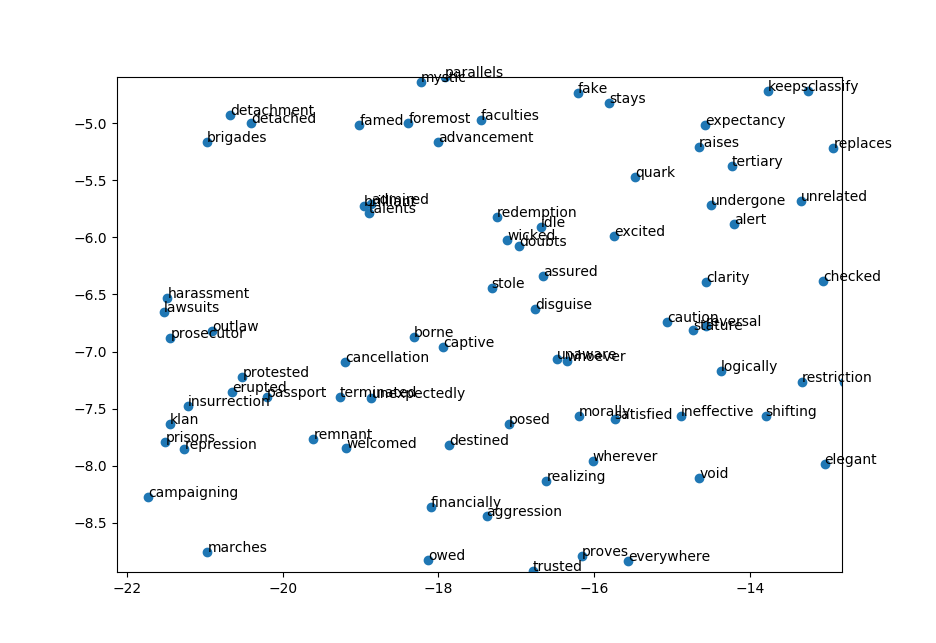

In [28]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib notebook
tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
Y = tsne.fit_transform(W[:1000,:])
plt.scatter(Y[:, 0], Y[:, 1])
for label, x, y in zip(ivoc[:1000], Y[:, 0], Y[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
plt.show()

### Results

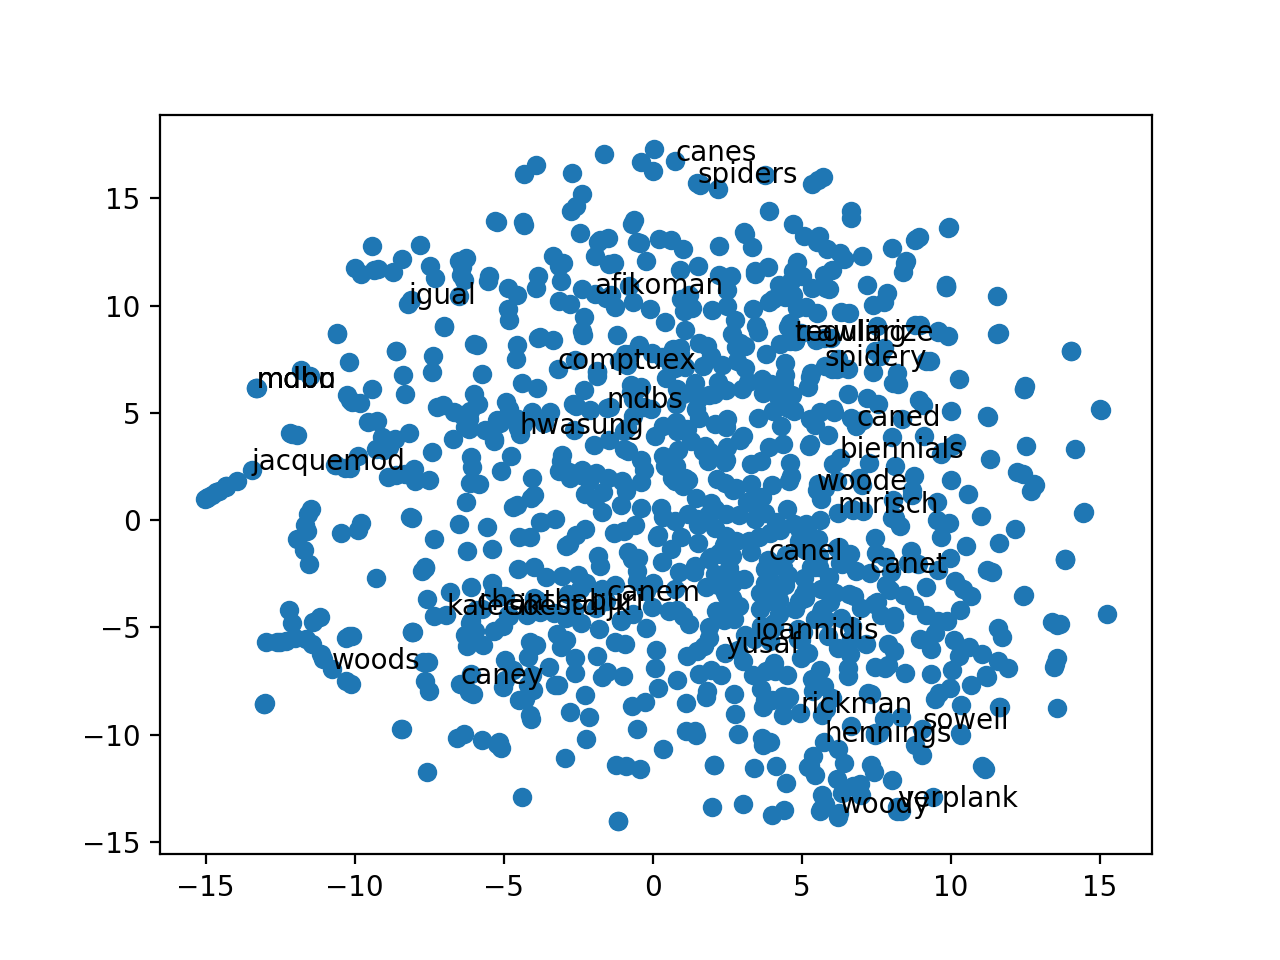

In [1]:
from IPython.display import Image
Image(filename='t-sne-big.png') 

Comments: Clusters of words with similar meaning/context are really rare in our analysis. Maybe there is something that we did incorrectly. 

In [4]:
spark.stop()